## Analiza statystyk z meczów w League of Legends w celu określenia kluczowych czynników decydujących o zwycięstwie przy użyciu technik ML

### Projekt przygotowany w ramach zaliczenia na zajęcia z Zastosowań Języka Python realizowanych na Uniwersytecie Warszawskim

### Wstęp

Stworzona przez Riot Games gra League of Legends (LoL) jest jedną z
najpopularniejszych gier online. Jest to wieloosobowa bitwa w realiach fantasy, która miała
premierę w 2009 roku. Ta strategiczna potyczka wymaga od graczy zarówno indywidualnych
umiejętności, jak i umiejętności pracy zespołowej, przy jednoczesnym balansowaniu między
zarządzaniem zasobami, a taktyką bitewną. Mecz LoL’a składa się z dwóch pięcioosobowych
drużyn, które walczą na mapie zwanej "Summoner's Rift". Każdy gracz kontroluje
unikalnego bohatera, inaczej znanego jako "champion". Wszystkie spośród ponad 140 postaci
mają przypisane umiejętności, które są unikalne dla każdej z nich. Na początku gry w fazie
wybierania postaci, zgodnie z deklarowanymi intencjami, zostają przypisane ścieżki do
poszczególnych graczy. Ścieżki te sygnalizują na których częściach mapy będą grali
poszczególni gracze. Na mapie są trzy ścieżki, zwane liniami - górna ("top"), środkowa
("mid") i dolna ("bot"), które prowadzą do bazy przeciwnika. Jest także obszar zwany
"jungle", gdzie gracze mogą zdobywać dodatkowe zasoby walcząc z neutralnymi stworami.
Celem gry jest zniszczenie bazy przeciwnika, zwanej Nexusem, przy jednoczesnej obronie
własnego Nexusa. Na wynik wpływa wiele czynników, takich jak zdolności bohaterów,
koordynacja zespołu, zarządzanie zasobami czy decyzje strategiczne. Dlatego analiza
statystyk z gier jest niezbędna, aby zrozumieć, które czynniki mają największy wpływ na
wynik meczu. Wykorzystanie technik uczenia maszynowego (ML) pozwoli na
przeprowadzenie bardziej zaawansowanej analizy.
Potrzeba przeprowadzenia takiej analizy wynika nie tylko z chęci zrozumienia gry na
fundamentalnym poziomie, ale również z chęci dostarczenia graczom informacji, które mogą
im pomóc poprawić swoje umiejętności i strategie. Jest to szczególnie istotne w kontekście
e-sportu, gdzie gracze i drużyny stale dążą do poszukiwania przewagi nad konkurencją.
Należy jednak zauważyć, że w badaniu trzeba by było uwzględnić znacznie więcej
zmiennych i obserwacji, żeby wyniki stanowiły istotną przesłankę dla najbardziej
zaawansowanych graczy. Dlatego w raporcie skupimy się na graczach
średnio/zaawansowanych, stosując techniki ML, spróbuję zrozumieć, które czynniki
wpływają najbardziej na wyniki rozgrywki na poszczególnych liniach.

#### Pozyskanie danych z użyciem API


In [ ]:
import requests
import pandas as pd
import time

api_key = 'RGAPI-29ae8128-9fa8-4f90-a644-7c4bf3a64a46'  # klucz API 
headers = {
    "X-Riot-Token": api_key
}

region = 'eun1'
tier = ['GOLD','PLATINUM','DIAMOND']
division = ['I','II','III','IV']

def get_summoners_in_league(region, tier, division):
    url = f"https://{region}.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/{tier}/{division}"
    response = requests.get(url, headers=headers)
    return response

def get_puuid(region, summoner_id):
    url=f"https://{region}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}"
    response = requests.get(url, headers=headers)
    return response

def get_matchlist(puuid_id):
    url = f"https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid_id}/ids?start=0&count=100"
    response = requests.get(url, headers=headers)
    return response

def get_match(match_id):
    url = f"https://europe.api.riotgames.com/lol/match/v5/matches/{match_id}"
    response = requests.get(url, headers=headers)
    return response

def handle_rate_limits(response):
    if 'X-App-Rate-Limit-Count' in response.headers:
        requests_made = response.headers['X-App-Rate-Limit-Count'].split(',')[-1] 
        requests_count, time_window = requests_made.split(':') 
        if int(requests_count) >= 100: 
            print("Rate limit reached. Waiting for 120 seconds.")
            time.sleep(120)

data = []
columns=['summonerName','kills','assists','deaths','championName','lane','champExperience',
         'dragonKills','baronKills','goldEarned','totalDamageDealtToChampions','totalHeal',
         'totalMinionsKilled','turretTakedowns','turretsLost','visionScore','timePlayed','win']

break_flag = False
response = get_summoners_in_league(region, tier, division)
handle_rate_limits(response) 
summoners = response.json()

for t in tier:
    for d in division:
        response = get_summoners_in_league(region, t, d)
        handle_rate_limits(response)  
        summoners = response.json()  
        for summoner in summoners:
            if break_flag:
                break
            else:
                summoner_id = summoner['summonerId']
                response = get_puuid(region, summoner_id)
                handle_rate_limits(response)  
                player_puuid = response.json()['puuid']

                response = get_matchlist(player_puuid)
                handle_rate_limits(response)  
                matchlist = response.json()
                for match in range(min(10, len(matchlist))): 
                    if len(data)>=9999:
                        break_flag=True
                        break
                    else:
                        response = get_match(matchlist[match])
                        handle_rate_limits(response)  
                        match_info = response.json()
                        if 'metadata' in match_info:
                            try:
                                player_index = match_info['metadata']['participants'].index(player_puuid)
                            except ValueError:
                                print(f"Player {player_puuid} not found in match participants.")
                                continue
                        else:
                            print(f"No 'metadata' in match info for match {matchlist[match]}. Skipping.")
                            continue

                        if 'info' in match_info:
                            try:
                                observation = []
                                observation.append(match_info['info']['participants'][player_index]['summonerName'])
                                observation.append(match_info['info']['participants'][player_index]['kills'])
                                observation.append(match_info['info']['participants'][player_index]['assists'])
                                observation.append(match_info['info']['participants'][player_index]['deaths'])
                                observation.append(match_info['info']['participants'][player_index]['championName'])
                                observation.append(match_info['info']['participants'][player_index]['lane'])
                                observation.append(match_info['info']['participants'][player_index]['champExperience'])
                                observation.append(match_info['info']['participants'][player_index]['dragonKills'])
                                observation.append(match_info['info']['participants'][player_index]['baronKills'])
                                observation.append(match_info['info']['participants'][player_index]['goldEarned'])
                                observation.append(match_info['info']['participants'][player_index]['totalDamageDealtToChampions'])
                                observation.append(match_info['info']['participants'][player_index]['totalHeal'])
                                observation.append(match_info['info']['participants'][player_index]['totalMinionsKilled'])
                                observation.append(match_info['info']['participants'][player_index]['turretTakedowns'])
                                observation.append(match_info['info']['participants'][player_index]['turretsLost'])
                                observation.append(match_info['info']['participants'][player_index]['visionScore'])
                                observation.append(match_info['info']['participants'][player_index]['timePlayed'])
                                observation.append(match_info['info']['participants'][player_index]['win'])
                                data.append(observation)
                            except KeyError:
                                continue
                        else:
                            print(f"No 'info' in match info for match {matchlist[match]}. Skipping.")
                            continue
                
df = pd.DataFrame(data, columns=columns)
df.to_csv('lol_data.csv', index=False, encoding='utf-8')

### Wczytanie bibliotek i danych

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn import preprocessing
import warnings
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from jupyter_dash import JupyterDash
import dash
from dash import dcc, html
from dash import dash_table
from dash.dependencies import Input, Output, State
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

warnings.filterwarnings('ignore')
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

In [88]:
data = pd.read_csv('lol_data.csv')

### Eksploracyjna analiza danych

In [89]:
data.head()

,summonerName,kills,assists,deaths,championName,lane,champExperience,dragonKills,baronKills,goldEarned,totalDamageDealtToChampions,totalHeal,totalMinionsKilled,turretTakedowns,turretsLost,visionScore,timePlayed,win
0,Dahyuns thighs,1,17,6,Zyra,BOTTOM,15920,0,0,9685,27715,3432,54,1,5,126,2366,True
1,Dahyuns thighs,1,22,11,Maokai,BOTTOM,15388,0,0,9914,20968,9123,42,1,8,107,2160,False
2,Dahyuns thighs,7,7,11,Zyra,BOTTOM,14332,0,0,12479,39719,4334,64,0,10,127,2425,False
3,Dahyuns thighs,2,14,2,Zyra,BOTTOM,6596,0,0,7736,11371,466,26,2,1,47,1251,True
4,Dahyuns thighs,35,16,11,Qiyana,MIDDLE,25731,0,0,22747,66780,2303,88,3,4,0,1295,False


In [90]:
data.shape

(9999, 18)

In [91]:
data.describe()

,kills,assists,deaths,champExperience,dragonKills,baronKills,goldEarned,totalDamageDealtToChampions,totalHeal,totalMinionsKilled,turretTakedowns,turretsLost,visionScore,timePlayed
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,7.349535,12.487549,7.535154,14770.635864,0.276928,0.077708,11961.574657,22103.453845,6855.596460,95.130013,1.858886,4.969197,21.816182,1611.518652
std,5.720776,9.845730,4.283878,6429.530819,0.714227,0.297792,4230.083011,14236.645143,7234.716012,75.342771,1.801010,3.584525,22.775982,488.028761
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,101.000000
25%,3.000000,5.000000,4.000000,10741.500000,0.000000,0.000000,9184.500000,11839.500000,1975.500000,31.000000,0.000000,2.000000,3.000000,1286.000000
50%,6.000000,10.000000,7.000000,14173.000000,0.000000,0.000000,11822.000000,19517.000000,4631.000000,66.000000,1.000000,4.000000,16.000000,1633.000000
75%,10.000000,17.000000,10.000000,17948.500000,0.000000,0.000000,14645.000000,29242.000000,9434.000000,160.000000,3.000000,8.000000,30.000000,1939.000000
max,45.000000,88.000000,41.000000,94422.000000,5.000000,3.000000,37657.000000,143377.000000,83801.000000,502.000000,11.000000,11.000000,164.000000,3854.000000


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   summonerName                 9999 non-null   object
 1   kills                        9999 non-null   int64 
 2   assists                      9999 non-null   int64 
 3   deaths                       9999 non-null   int64 
 4   championName                 9999 non-null   object
 5   lane                         9999 non-null   object
 6   champExperience              9999 non-null   int64 
 7   dragonKills                  9999 non-null   int64 
 8   baronKills                   9999 non-null   int64 
 9   goldEarned                   9999 non-null   int64 
 10  totalDamageDealtToChampions  9999 non-null   int64 
 11  totalHeal                    9999 non-null   int64 
 12  totalMinionsKilled           9999 non-null   int64 
 13  turretTakedowns              9999

In [93]:
data.duplicated().sum()

27

In [94]:
data[data.duplicated(keep = False)]

,summonerName,kills,assists,deaths,championName,lane,champExperience,dragonKills,baronKills,goldEarned,totalDamageDealtToChampions,totalHeal,totalMinionsKilled,turretTakedowns,turretsLost,visionScore,timePlayed,win
2660,Gargata,5,8,8,Warwick,JUNGLE,13929,1,0,11130,13473,23969,48,0,10,18,1920,False
2661,Gargata,5,12,7,Malphite,BOTTOM,14460,0,0,11119,20986,2733,41,0,7,55,2093,True
2662,Gargata,5,10,0,Karthus,JUNGLE,12980,0,0,11595,18182,14837,26,3,1,14,1506,True
2663,Gargata,4,6,4,Warwick,JUNGLE,16329,1,1,11982,14210,31444,28,2,2,25,1953,True
2664,Gargata,5,12,3,Warwick,JUNGLE,15400,1,1,11899,15813,29808,40,5,3,26,1848,True
2665,Gargata,3,7,4,Warwick,JUNGLE,10497,0,1,9232,7896,16835,18,5,1,18,1442,True
2666,Gargata,10,9,0,Warwick,JUNGLE,13875,2,0,12674,15763,20107,18,2,1,23,1628,True
2667,Gargata,4,5,5,Malphite,JUNGLE,11279,0,0,10555,11116,8631,35,0,9,16,1656,False
2668,Gargata,0,0,0,Warwick,NONE,525,0,0,776,0,903,0,0,0,1,161,True
3040,Wu Cream,1,1,4,MissFortune,NONE,4451,0,0,4528,3975,1146,92,0,3,4,914,False


In [95]:
data = data[data.duplicated() == False]
data.shape

(9972, 18)

In [96]:
data.lane.unique()

array(['BOTTOM', 'MIDDLE', 'NONE', 'JUNGLE', 'TOP'], dtype=object)

In [97]:
data = data.query('lane != "NONE"')
data.lane.unique()

array(['BOTTOM', 'MIDDLE', 'JUNGLE', 'TOP'], dtype=object)

In [98]:
print(data.win.value_counts())
print()
print(data.win.value_counts(normalize = True))

win
False    4005
True     3976
Name: count, dtype: int64

win
False    0.501817
True     0.498183
Name: proportion, dtype: float64


In [99]:
data.championName.nunique()

163

In [100]:
data.championName.value_counts().head(10)

championName
Caitlyn        180
Lux            178
Ezreal         163
Jhin           147
Thresh         133
MissFortune    129
Senna          126
Ashe           123
Shaco          114
Kaisa          113
Name: count, dtype: int64

### Zrozumienie i przygotowanie zmiennych

In [101]:
data.head()

,summonerName,kills,assists,deaths,championName,lane,champExperience,dragonKills,baronKills,goldEarned,totalDamageDealtToChampions,totalHeal,totalMinionsKilled,turretTakedowns,turretsLost,visionScore,timePlayed,win
0,Dahyuns thighs,1,17,6,Zyra,BOTTOM,15920,0,0,9685,27715,3432,54,1,5,126,2366,True
1,Dahyuns thighs,1,22,11,Maokai,BOTTOM,15388,0,0,9914,20968,9123,42,1,8,107,2160,False
2,Dahyuns thighs,7,7,11,Zyra,BOTTOM,14332,0,0,12479,39719,4334,64,0,10,127,2425,False
3,Dahyuns thighs,2,14,2,Zyra,BOTTOM,6596,0,0,7736,11371,466,26,2,1,47,1251,True
4,Dahyuns thighs,35,16,11,Qiyana,MIDDLE,25731,0,0,22747,66780,2303,88,3,4,0,1295,False


In [102]:
data.describe()

,kills,assists,deaths,champExperience,dragonKills,baronKills,goldEarned,totalDamageDealtToChampions,totalHeal,totalMinionsKilled,turretTakedowns,turretsLost,visionScore,timePlayed
count,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000
mean,7.501566,12.203483,7.751284,15578.260243,0.331913,0.096855,12628.628994,23593.129057,7677.375392,107.560581,2.044857,5.734369,26.343315,1784.419371
std,5.632003,9.414338,4.149604,6210.144621,0.775547,0.329831,3913.040018,14363.515891,7604.266627,77.140280,1.844111,3.476034,23.142420,356.033005
min,0.000000,0.000000,0.000000,986.000000,0.000000,0.000000,3988.000000,583.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1200.000000
25%,3.000000,6.000000,5.000000,11378.000000,0.000000,0.000000,9679.000000,13285.000000,2491.000000,36.000000,1.000000,3.000000,12.000000,1510.000000
50%,6.000000,10.000000,7.000000,14394.000000,0.000000,0.000000,12245.000000,20505.000000,5389.000000,90.000000,2.000000,5.000000,20.000000,1749.000000
75%,10.000000,16.000000,10.000000,18351.000000,0.000000,0.000000,15184.000000,30543.000000,10692.000000,173.000000,3.000000,9.000000,35.000000,2015.000000
max,45.000000,88.000000,41.000000,94422.000000,5.000000,3.000000,37657.000000,143377.000000,83801.000000,502.000000,11.000000,11.000000,164.000000,3854.000000


In [103]:
data_numerical = data[['kills', 'assists', 'deaths', 'champExperience', 'dragonKills',
       'baronKills', 'goldEarned', 'totalDamageDealtToChampions', 'totalHeal',
       'totalMinionsKilled', 'turretTakedowns', 'turretsLost', 'visionScore',
       'timePlayed']]
data_numerical

,kills,assists,deaths,champExperience,dragonKills,baronKills,goldEarned,totalDamageDealtToChampions,totalHeal,totalMinionsKilled,turretTakedowns,turretsLost,visionScore,timePlayed
0,1,17,6,15920,0,0,9685,27715,3432,54,1,5,126,2366
1,1,22,11,15388,0,0,9914,20968,9123,42,1,8,107,2160
2,7,7,11,14332,0,0,12479,39719,4334,64,0,10,127,2425
3,2,14,2,6596,0,0,7736,11371,466,26,2,1,47,1251
4,35,16,11,25731,0,0,22747,66780,2303,88,3,4,0,1295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,15,8,7,21593,4,0,18474,26244,22046,62,4,10,37,2517
9994,7,6,1,11006,1,1,10707,11289,8161,30,4,1,17,1353
9995,5,17,5,14838,3,1,12121,19260,12660,33,5,1,15,1826
9996,4,5,7,12968,0,0,10659,18407,4555,149,1,10,33,1871


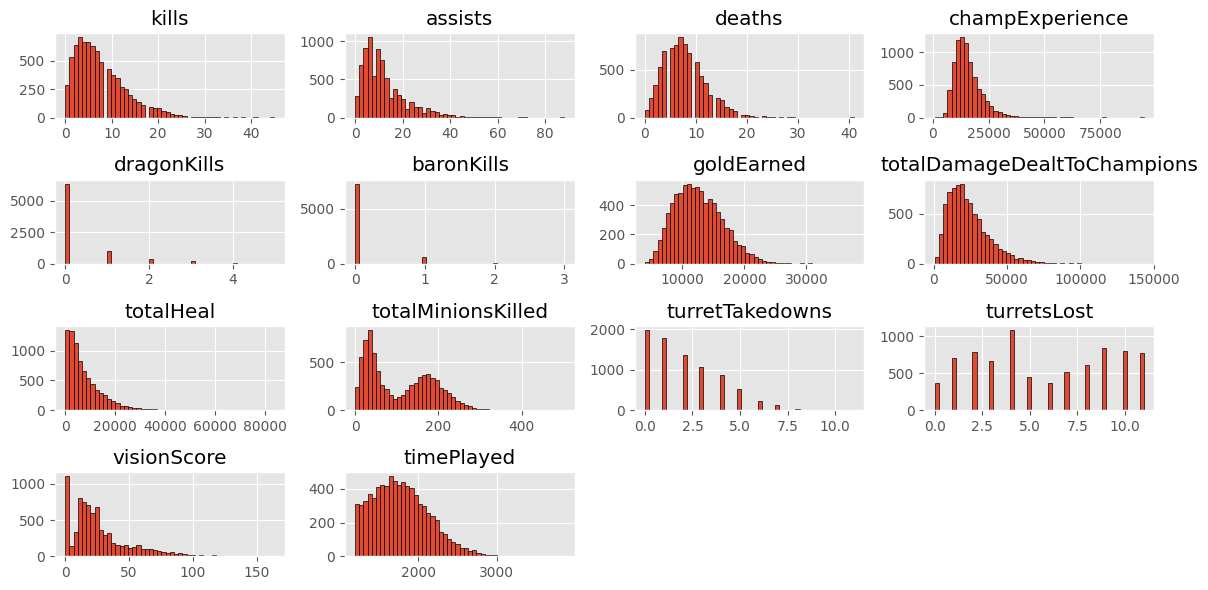

In [104]:
data_numerical.hist(bins = 50, edgecolor = 'black')
plt.tight_layout()
plt.show()

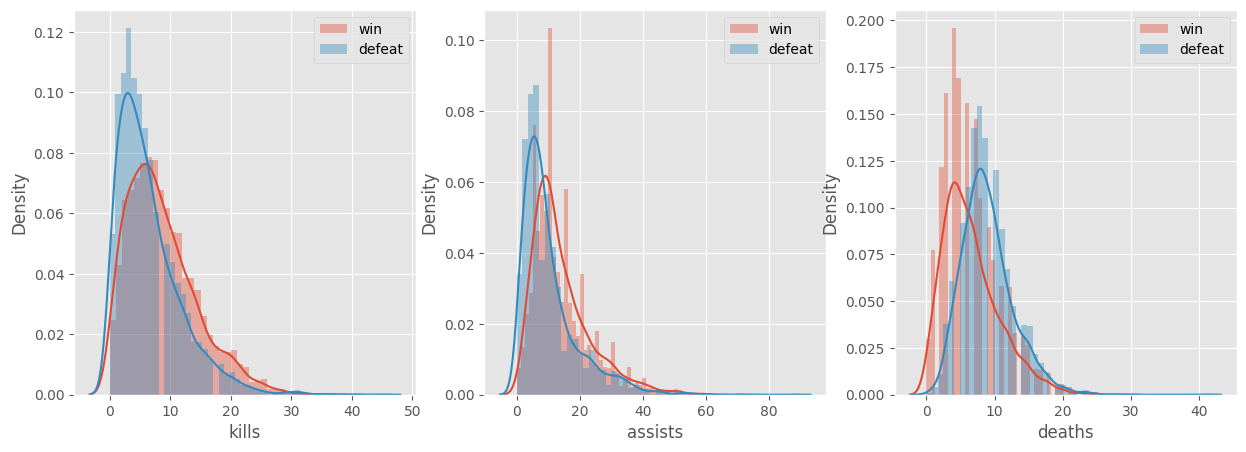

In [105]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.distplot(data.query('win == 1')['kills'], label = 'win')
sns.distplot(data.query('win == 0')['kills'], label = 'defeat')
plt.legend()

plt.subplot(1,3,2)
sns.distplot(data.query('win == 1')['assists'], label = 'win')
sns.distplot(data.query('win == 0')['assists'], label = 'defeat')
plt.legend()

plt.subplot(1,3,3)
sns.distplot(data.query('win == 1')['deaths'], label = 'win')
sns.distplot(data.query('win == 0')['deaths'], label = 'defeat')
plt.legend()

plt.show()

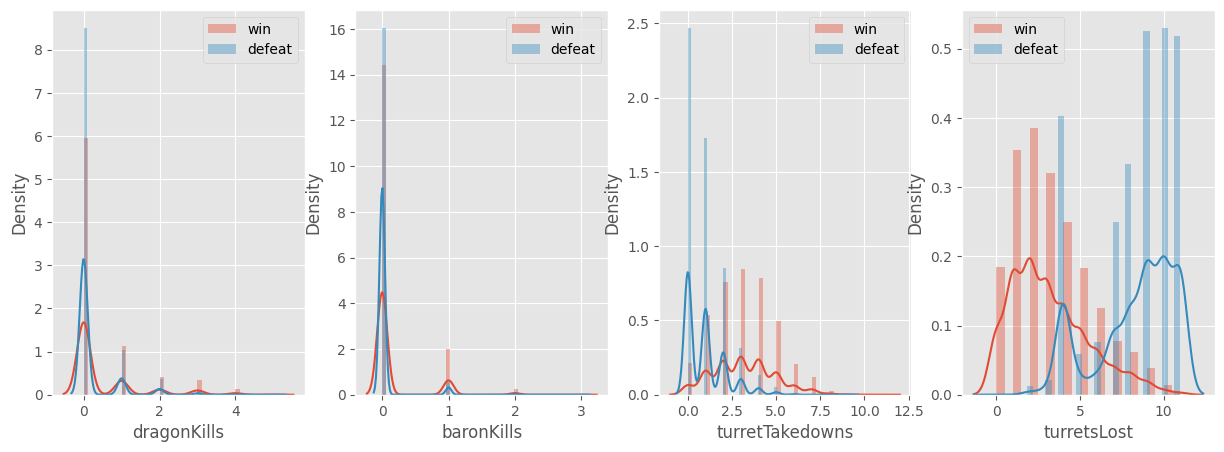

In [106]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
sns.distplot(data.query('win == 1')['dragonKills'], label = 'win')
sns.distplot(data.query('win == 0')['dragonKills'], label = 'defeat')
plt.legend()

plt.subplot(1,4,2)
sns.distplot(data.query('win == 1')['baronKills'], label = 'win')
sns.distplot(data.query('win == 0')['baronKills'], label = 'defeat')
plt.legend()

plt.subplot(1,4,3)
sns.distplot(data.query('win == 1')['turretTakedowns'], label = 'win')
sns.distplot(data.query('win == 0')['turretTakedowns'], label = 'defeat')
plt.legend()

plt.subplot(1,4,4)
sns.distplot(data.query('win == 1')['turretsLost'], label = 'win')
sns.distplot(data.query('win == 0')['turretsLost'], label = 'defeat')
plt.legend()

plt.show()

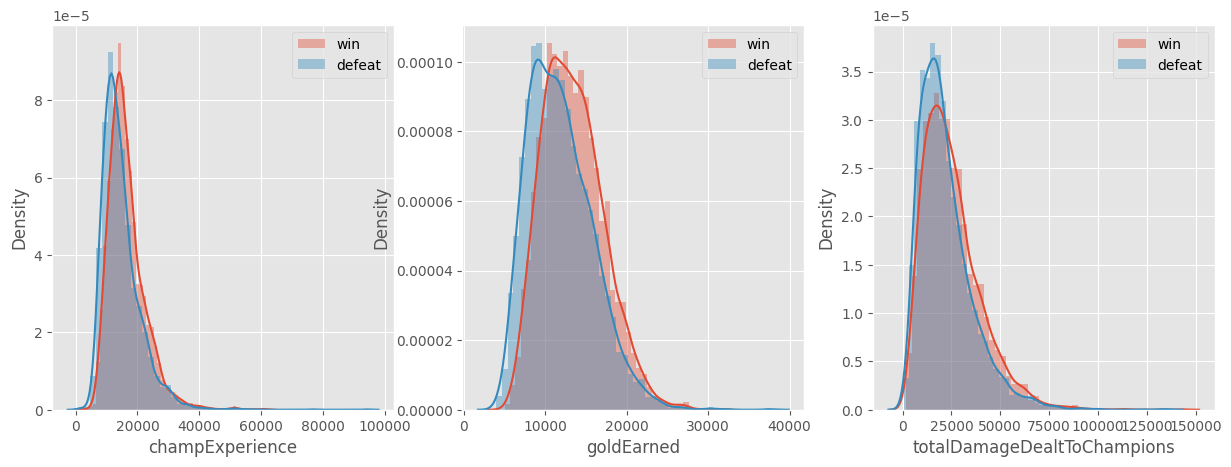

In [107]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.distplot(data.query('win == 1')['champExperience'], label = 'win')
sns.distplot(data.query('win == 0')['champExperience'], label = 'defeat')
plt.legend()

plt.subplot(1,3,2)
sns.distplot(data.query('win == 1')['goldEarned'], label = 'win')
sns.distplot(data.query('win == 0')['goldEarned'], label = 'defeat')
plt.legend()

plt.subplot(1,3,3)
sns.distplot(data.query('win == 1')['totalDamageDealtToChampions'], label = 'win')
sns.distplot(data.query('win == 0')['totalDamageDealtToChampions'], label = 'defeat')
plt.legend()

plt.show()

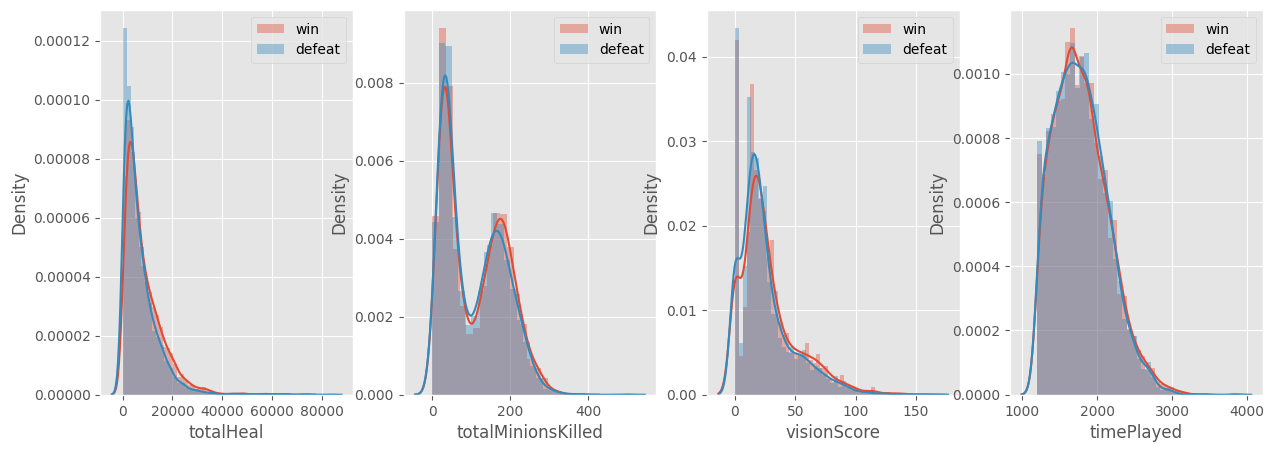

In [108]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
sns.distplot(data.query('win == 1')['totalHeal'], label = 'win')
sns.distplot(data.query('win == 0')['totalHeal'], label = 'defeat')
plt.legend()

plt.subplot(1,4,2)
sns.distplot(data.query('win == 1')['totalMinionsKilled'], label = 'win')
sns.distplot(data.query('win == 0')['totalMinionsKilled'], label = 'defeat')
plt.legend()

plt.subplot(1,4,3)
sns.distplot(data.query('win == 1')['visionScore'], label = 'win')
sns.distplot(data.query('win == 0')['visionScore'], label = 'defeat')
plt.legend()

plt.subplot(1,4,4)
sns.distplot(data.query('win == 1')['timePlayed'], label = 'win')
sns.distplot(data.query('win == 0')['timePlayed'], label = 'defeat')
plt.legend()

plt.show()

In [109]:
data_categorical = data[['summonerName', 'lane', 'win']]

In [110]:
data_categorical.lane.value_counts()

lane
BOTTOM    3252
TOP       1656
MIDDLE    1601
JUNGLE    1472
Name: count, dtype: int64

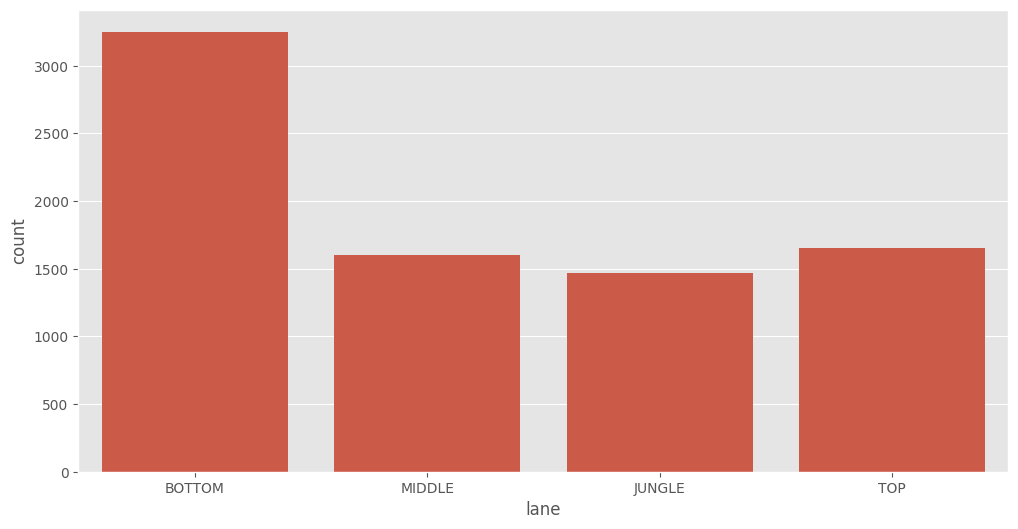

In [111]:
sns.countplot(x = 'lane', data = data_categorical)
plt.show()

In [112]:
data_categorical.win.value_counts()

win
False    4005
True     3976
Name: count, dtype: int64

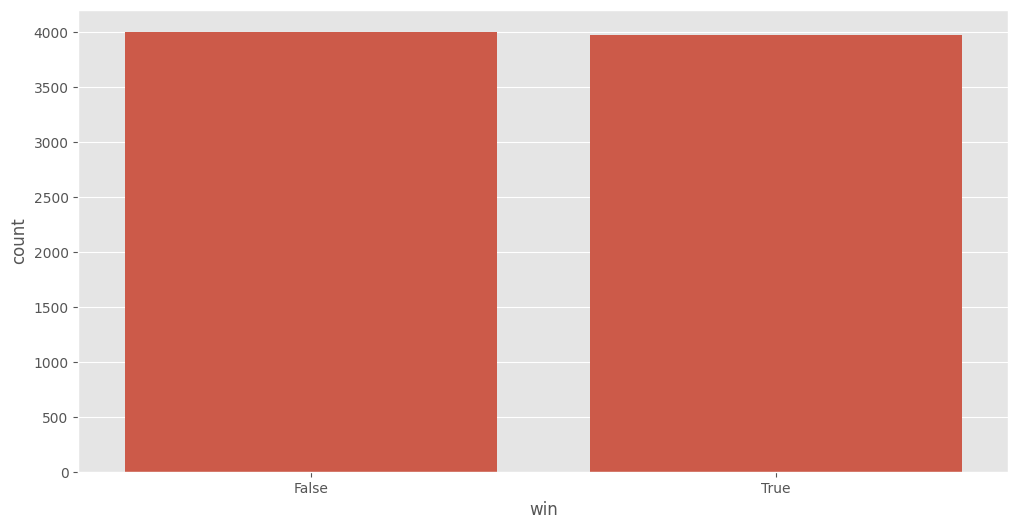

In [113]:
sns.countplot(x = 'win', data = data_categorical)
plt.show()

### Badanie relacji między zmiennymi

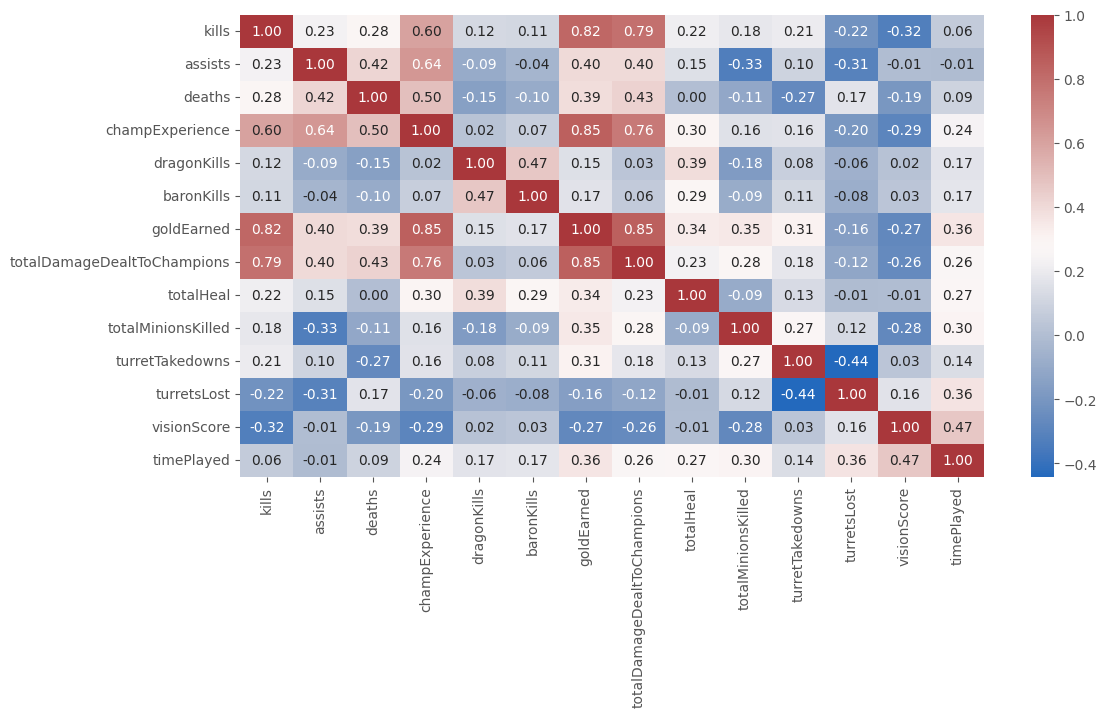

In [114]:
sns.heatmap(data_numerical.corr(), cmap = 'vlag', annot = True, fmt = '.2f')
plt.show()

In [115]:
data_numerical.drop(['goldEarned', 'totalDamageDealtToChampions', 'champExperience', 'timePlayed'], axis = 1, inplace = True)

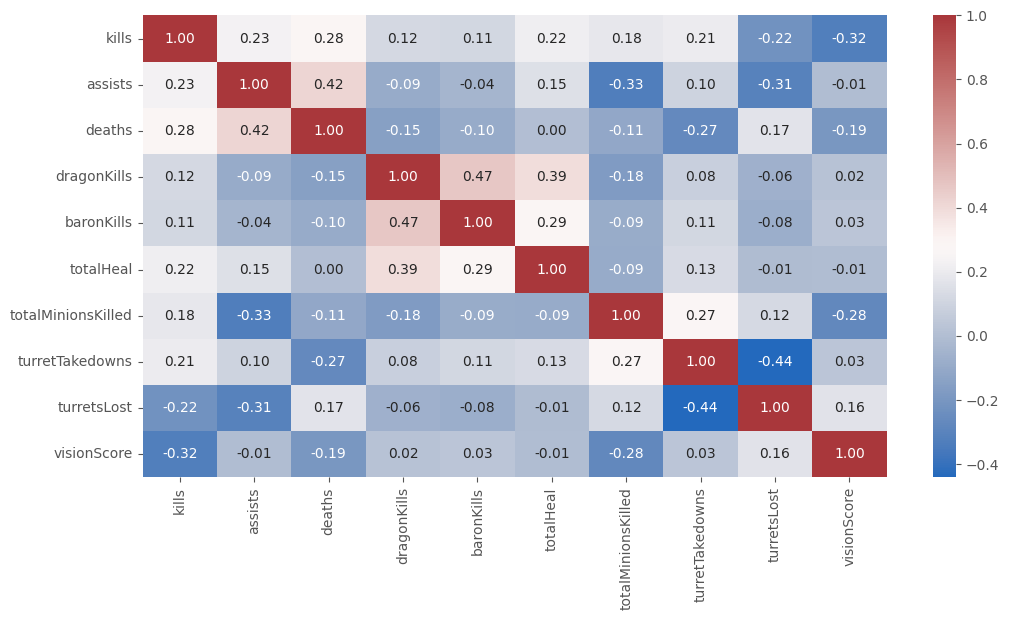

In [116]:
sns.heatmap(data_numerical.corr(), cmap = 'vlag', annot = True, fmt = '.2f')
plt.show()

In [117]:
data_numerical_plus_kills = data_numerical.join(data['win'])

In [118]:
# sns.pairplot(data_numerical_plus_kills, hue = 'win')
# plt.show()

### Modele

In [119]:
model_data = data.drop(['summonerName', 'championName'], axis = 1)
model_data['win'] = [1 if x == True else 0 for x in model_data['win']]
model_data

,kills,assists,deaths,lane,champExperience,dragonKills,baronKills,goldEarned,totalDamageDealtToChampions,totalHeal,totalMinionsKilled,turretTakedowns,turretsLost,visionScore,timePlayed,win
0,1,17,6,BOTTOM,15920,0,0,9685,27715,3432,54,1,5,126,2366,1
1,1,22,11,BOTTOM,15388,0,0,9914,20968,9123,42,1,8,107,2160,0
2,7,7,11,BOTTOM,14332,0,0,12479,39719,4334,64,0,10,127,2425,0
3,2,14,2,BOTTOM,6596,0,0,7736,11371,466,26,2,1,47,1251,1
4,35,16,11,MIDDLE,25731,0,0,22747,66780,2303,88,3,4,0,1295,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,15,8,7,JUNGLE,21593,4,0,18474,26244,22046,62,4,10,37,2517,0
9994,7,6,1,JUNGLE,11006,1,1,10707,11289,8161,30,4,1,17,1353,1
9995,5,17,5,JUNGLE,14838,3,1,12121,19260,12660,33,5,1,15,1826,1
9996,4,5,7,MIDDLE,12968,0,0,10659,18407,4555,149,1,10,33,1871,0


In [120]:
model_data.lane.unique()

array(['BOTTOM', 'MIDDLE', 'JUNGLE', 'TOP'], dtype=object)

In [121]:
model_data_bottom = model_data.query('lane == "BOTTOM"')
print(model_data_bottom.shape)

model_data_middle = model_data.query('lane == "MIDDLE"')
print(model_data_middle.shape)

model_data_jungle = model_data.query('lane == "JUNGLE"')
print(model_data_jungle.shape)

model_data_top = model_data.query('lane == "TOP"')
print(model_data_top.shape)

(3252, 16)
(1601, 16)
(1472, 16)
(1656, 16)


In [122]:
# model bottom
X_train, X_test, y_train, y_test = train_test_split(model_data_bottom.drop('win', axis = 1), model_data_bottom['win'], test_size=0.3, random_state=123)
train = X_train.join(y_train)
test = X_test.join(y_test)

train.drop('lane', axis = 1, inplace = True)
test.drop('lane', axis = 1, inplace = True)

scaler = MinMaxScaler()
train_normalized = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
test_normalizd = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)


model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

Optimization terminated successfully.
         Current function value: 0.125117
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 2276
Model:                          Logit   Df Residuals:                     2261
Method:                           MLE   Df Model:                           14
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.8194
Time:                        23:44:25   Log-Likelihood:                -284.77
converged:                       True   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.1297      0.586      3.637      0.000       0.982       3.278
kills                           4.4442      2.171      2.047      0.041       0.189       8.699
assists                         6.3028      1.355      4.650      0.000       3.646       8.959
deaths                         -1.9420      0.883     -2.198      0.028      -3.673      -0.211
champExperience                 5.9187      3.716      1.593      0.111      -1.364      13.201
dragonKills                     0.4969      0.906      0.549      0.583      -1.278       2.272
baronKills                      0.8412      1.014      0.830      0.407      -1.146       2.828
goldEarned                     -6.3592      4.787     -1.328      0.184     -15.742       3.023
totalDamageDealtToChampions    -3.3053      1.563     -2.115      0.034      -6.369      -0.242
totalHeal                      -1.7097      1.299     -1.316      0.188      -4.255       0.836
totalMinionsKilled              3.5995      1.373      2.622      0.009       0.909       6.290
turretTakedowns                 8.1052      0.840      9.644      0.000       6.458       9.752
turretsLost                   -14.8293      0.884    -16.767      0.000     -16.563     -13.096
visionScore                     3.9781      1.088      3.657      0.000       1.846       6.110
timePlayed                      7.3080      1.771      4.128      0.000       3.838      10.778
===============================================================================================
"""

In [123]:
# usuwanie zmiennych statystycznie nieistotnych na podstawie wartości p-value

In [124]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

Optimization terminated successfully.
         Current function value: 0.125184
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 2276
Model:                          Logit   Df Residuals:                     2262
Method:                           MLE   Df Model:                           13
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.8193
Time:                        23:44:26   Log-Likelihood:                -284.92
converged:                       True   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.1298      0.584      3.645      0.000       0.985       3.275
kills                           4.5380      2.165      2.096      0.036       0.294       8.782
assists                         6.3609      1.352      4.703      0.000       3.710       9.012
deaths                         -1.9307      0.881     -2.191      0.028      -3.658      -0.204
champExperience                 5.7986      3.710      1.563      0.118      -1.473      13.070
baronKills                      0.8104      1.011      0.801      0.423      -1.172       2.793
goldEarned                     -6.4455      4.788     -1.346      0.178     -15.830       2.939
totalDamageDealtToChampions    -3.2674      1.561     -2.093      0.036      -6.327      -0.208
totalHeal                      -1.6793      1.298     -1.294      0.196      -4.223       0.865
totalMinionsKilled              3.7225      1.354      2.749      0.006       1.068       6.377
turretTakedowns                 8.1293      0.839      9.694      0.000       6.486       9.773
turretsLost                   -14.8517      0.885    -16.790      0.000     -16.585     -13.118
visionScore                     3.9811      1.086      3.666      0.000       1.853       6.110
timePlayed                      7.3350      1.767      4.151      0.000       3.872      10.798
===============================================================================================
"""

In [125]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

Optimization terminated successfully.
         Current function value: 0.125325
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 2276
Model:                          Logit   Df Residuals:                     2263
Method:                           MLE   Df Model:                           12
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.8191
Time:                        23:44:26   Log-Likelihood:                -285.24
converged:                       True   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.1331      0.585      3.647      0.000       0.987       3.279
kills                           4.4456      2.151      2.067      0.039       0.230       8.662
assists                         6.3429      1.349      4.700      0.000       3.698       8.988
deaths                         -1.9276      0.880     -2.190      0.029      -3.653      -0.202
champExperience                 5.6415      3.688      1.530      0.126      -1.586      12.869
goldEarned                     -6.1907      4.758     -1.301      0.193     -15.517       3.135
totalDamageDealtToChampions    -3.2473      1.558     -2.085      0.037      -6.300      -0.195
totalHeal                      -1.6821      1.301     -1.293      0.196      -4.233       0.868
totalMinionsKilled              3.7506      1.352      2.774      0.006       1.101       6.401
turretTakedowns                 8.1386      0.839      9.701      0.000       6.494       9.783
turretsLost                   -14.8520      0.884    -16.810      0.000     -16.584     -13.120
visionScore                     3.9951      1.088      3.672      0.000       1.863       6.128
timePlayed                      7.2975      1.765      4.135      0.000       3.838      10.757
===============================================================================================
"""

In [126]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + goldEarned + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

Optimization terminated successfully.
         Current function value: 0.125685
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 2276
Model:                          Logit   Df Residuals:                     2264
Method:                           MLE   Df Model:                           11
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.8186
Time:                        23:44:27   Log-Likelihood:                -286.06
converged:                       True   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.1208      0.586      3.619      0.000       0.972       3.269
kills                           4.2814      2.141      2.000      0.046       0.086       8.477
assists                         6.1586      1.342      4.588      0.000       3.528       8.789
deaths                         -1.8307      0.877     -2.087      0.037      -3.550      -0.111
champExperience                 5.4753      3.687      1.485      0.138      -1.752      12.702
goldEarned                     -6.3071      4.751     -1.328      0.184     -15.619       3.005
totalDamageDealtToChampions    -2.9992      1.543     -1.944      0.052      -6.023       0.025
totalMinionsKilled              3.8224      1.349      2.833      0.005       1.178       6.467
turretTakedowns                 7.9953      0.827      9.664      0.000       6.374       9.617
turretsLost                   -14.8170      0.876    -16.922      0.000     -16.533     -13.101
visionScore                     4.1011      1.087      3.772      0.000       1.970       6.232
timePlayed                      6.8586      1.728      3.970      0.000       3.473      10.245
===============================================================================================
"""

In [127]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

Optimization terminated successfully.
         Current function value: 0.126076
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 2276
Model:                          Logit   Df Residuals:                     2265
Method:                           MLE   Df Model:                           10
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.8181
Time:                        23:44:27   Log-Likelihood:                -286.95
converged:                       True   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.3638      0.558      4.236      0.000       1.270       3.458
kills                           2.0354      1.293      1.575      0.115      -0.498       4.569
assists                         5.8233      1.313      4.436      0.000       3.250       8.396
deaths                         -1.9622      0.869     -2.259      0.024      -3.665      -0.259
champExperience                 2.2668      2.758      0.822      0.411      -3.138       7.672
totalDamageDealtToChampions    -3.3816      1.511     -2.238      0.025      -6.343      -0.421
totalMinionsKilled              2.6755      1.026      2.608      0.009       0.665       4.686
turretTakedowns                 7.6798      0.785      9.778      0.000       6.141       9.219
turretsLost                   -14.8865      0.879    -16.931      0.000     -16.610     -13.163
visionScore                     4.0031      1.083      3.697      0.000       1.881       6.125
timePlayed                      6.3736      1.675      3.805      0.000       3.091       9.656
===============================================================================================
"""

In [128]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

Optimization terminated successfully.
         Current function value: 0.126226
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 2276
Model:                          Logit   Df Residuals:                     2266
Method:                           MLE   Df Model:                            9
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.8178
Time:                        23:44:27   Log-Likelihood:                -287.29
converged:                       True   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.5172      0.526      4.783      0.000       1.486       3.549
kills                           2.3724      1.223      1.939      0.052      -0.025       4.770
assists                         6.4550      1.073      6.015      0.000       4.352       8.558
deaths                         -1.8265      0.851     -2.146      0.032      -3.495      -0.158
totalDamageDealtToChampions    -3.2819      1.502     -2.185      0.029      -6.225      -0.339
totalMinionsKilled              2.8528      1.005      2.839      0.005       0.883       4.823
turretTakedowns                 7.6941      0.784      9.816      0.000       6.158       9.230
turretsLost                   -14.9505      0.878    -17.020      0.000     -16.672     -13.229
visionScore                     3.8559      1.066      3.615      0.000       1.766       5.946
timePlayed                      6.9456      1.520      4.569      0.000       3.966       9.925
===============================================================================================
"""

In [129]:
model_bottom = smf.logit(formula = 'win ~ assists + deaths + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

Optimization terminated successfully.


         Current function value: 0.127057
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 2276
Model:                          Logit   Df Residuals:                     2267
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.8166
Time:                        23:44:28   Log-Likelihood:                -289.18
converged:                       True   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.6662      0.519      5.141      0.000       1.650       3.683
assists                         6.0667      1.050      5.779      0.000       4.009       8.124
deaths                         -1.7741      0.850     -2.088      0.037      -3.440      -0.109
totalDamageDealtToChampions    -1.1351      1.012     -1.122      0.262      -3.119       0.849
totalMinionsKilled              2.9597      1.001      2.958      0.003       0.999       4.921
turretTakedowns                 7.9078      0.776     10.192      0.000       6.387       9.428
turretsLost                   -14.9834      0.875    -17.121      0.000     -16.699     -13.268
visionScore                     3.8343      1.068      3.590      0.000       1.741       5.928
timePlayed                      6.5401      1.491      4.388      0.000       3.619       9.462
===============================================================================================
"""

In [130]:
model_bottom = smf.logit(formula = 'win ~ assists + deaths + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

Optimization terminated successfully.
         Current function value: 0.127336
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 2276
Model:                          Logit   Df Residuals:                     2268
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.8162
Time:                        23:44:28   Log-Likelihood:                -289.82
converged:                       True   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.7253      0.515      5.294      0.000       1.716       3.734
assists                5.8363      1.026      5.689      0.000       3.825       7.847
deaths                -2.0683      0.809     -2.557      0.011      -3.654      -0.483
totalMinionsKilled     2.5954      0.945      2.746      0.006       0.743       4.448
turretTakedowns        7.8120      0.769     10.162      0.000       6.305       9.319
turretsLost          -14.9023      0.869    -17.147      0.000     -16.606     -13.199
visionScore            3.8919      1.064      3.659      0.000       1.807       5.977
timePlayed             6.2545      1.469      4.259      0.000       3.376       9.133
======================================================================================
"""

In [131]:
model_bottom_prediction = model_bottom.predict(test_normalizd) > 0.5
accuracy_bottom = accuracy_score(model_bottom_prediction, y_test)
accuracy_bottom

0.923155737704918

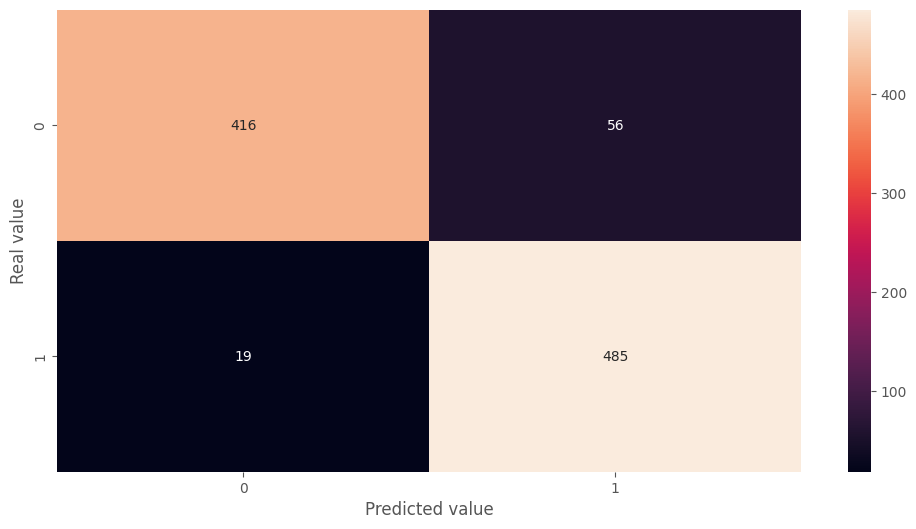

In [132]:
cm_bottom = confusion_matrix(y_test, model_bottom_prediction)

sns.heatmap(cm_bottom, annot=True, fmt="d")
plt.ylabel('Real value')
plt.xlabel('Predicted value')
plt.show()

In [133]:
# model middle
X_train, X_test, y_train, y_test = train_test_split(model_data_middle.drop('win', axis = 1), model_data_middle['win'], test_size=0.3, random_state=123)
train = X_train.join(y_train)
test = X_test.join(y_test)

train.drop('lane', axis = 1, inplace = True)
test.drop('lane', axis = 1, inplace = True)

scaler = MinMaxScaler()
train_normalized = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
test_normalizd = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_middle.summary()

Optimization terminated successfully.
         Current function value: 0.195653
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1105
Method:                           MLE   Df Model:                           14
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7175
Time:                        23:44:28   Log-Likelihood:                -219.13
converged:                       True   LL-Null:                       -775.75
Covariance Type:            nonrobust   LLR p-value:                7.693e-229
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       3.7137      0.712      5.216      0.000       2.318       5.109
kills                           4.3825      1.670      2.624      0.009       1.110       7.656
assists                         5.2736      1.879      2.807      0.005       1.591       8.956
deaths                         -2.7397      1.116     -2.455      0.014      -4.927      -0.552
champExperience                -8.5495      2.829     -3.022      0.003     -14.094      -3.005
dragonKills                     1.6386      1.292      1.268      0.205      -0.893       4.171
baronKills                      0.0104      1.499      0.007      0.994      -2.928       2.948
goldEarned                     -2.9577      3.024     -0.978      0.328      -8.885       2.969
totalDamageDealtToChampions    -1.9472      1.950     -0.998      0.318      -5.770       1.876
totalHeal                      -0.0567      1.083     -0.052      0.958      -2.180       2.066
totalMinionsKilled              3.3800      1.835      1.842      0.065      -0.216       6.977
turretTakedowns                 8.6902      1.051      8.265      0.000       6.629      10.751
turretsLost                   -14.5921      1.077    -13.543      0.000     -16.704     -12.480
visionScore                    -1.8335      1.750     -1.048      0.295      -5.263       1.596
timePlayed                     11.3252      1.613      7.021      0.000       8.164      14.486
===============================================================================================
"""

In [134]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_middle.summary()

Optimization terminated successfully.
         Current function value: 0.195653
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1106
Method:                           MLE   Df Model:                           13
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7175
Time:                        23:44:28   Log-Likelihood:                -219.13
converged:                       True   LL-Null:                       -775.75
Covariance Type:            nonrobust   LLR p-value:                8.148e-230
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       3.7135      0.711      5.220      0.000       2.319       5.108
kills                           4.3817      1.665      2.631      0.009       1.118       7.646
assists                         5.2728      1.875      2.812      0.005       1.598       8.948
deaths                         -2.7397      1.116     -2.455      0.014      -4.927      -0.552
champExperience                -8.5490      2.828     -3.023      0.003     -14.092      -3.006
dragonKills                     1.6418      1.207      1.360      0.174      -0.724       4.007
goldEarned                     -2.9569      3.022     -0.978      0.328      -8.880       2.966
totalDamageDealtToChampions    -1.9464      1.948     -0.999      0.318      -5.764       1.871
totalHeal                      -0.0561      1.079     -0.052      0.959      -2.172       2.059
totalMinionsKilled              3.3805      1.834      1.844      0.065      -0.213       6.974
turretTakedowns                 8.6904      1.051      8.270      0.000       6.631      10.750
turretsLost                   -14.5923      1.077    -13.547      0.000     -16.703     -12.481
visionScore                    -1.8323      1.741     -1.052      0.293      -5.245       1.580
timePlayed                     11.3244      1.609      7.038      0.000       8.171      14.478
===============================================================================================
"""

In [135]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + goldEarned + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_middle.summary()

Optimization terminated successfully.
         Current function value: 0.195655
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1107
Method:                           MLE   Df Model:                           12
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7175
Time:                        23:44:29   Log-Likelihood:                -219.13
converged:                       True   LL-Null:                       -775.75
Covariance Type:            nonrobust   LLR p-value:                8.289e-231
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       3.7096      0.707      5.243      0.000       2.323       5.096
kills                           4.3835      1.665      2.633      0.008       1.121       7.646
assists                         5.2643      1.868      2.819      0.005       1.604       8.925
deaths                         -2.7269      1.088     -2.505      0.012      -4.860      -0.594
champExperience                -8.5580      2.822     -3.032      0.002     -14.090      -3.026
dragonKills                     1.6423      1.208      1.360      0.174      -0.724       4.009
goldEarned                     -2.9754      3.001     -0.991      0.321      -8.857       2.906
totalDamageDealtToChampions    -1.9289      1.918     -1.006      0.315      -5.689       1.831
totalMinionsKilled              3.3938      1.816      1.869      0.062      -0.166       6.953
turretTakedowns                 8.6897      1.051      8.269      0.000       6.630      10.749
turretsLost                   -14.5947      1.076    -13.561      0.000     -16.704     -12.485
visionScore                    -1.8327      1.741     -1.052      0.293      -5.246       1.580
timePlayed                     11.3191      1.606      7.049      0.000       8.172      14.467
===============================================================================================
"""

In [136]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_middle.summary()

Optimization terminated successfully.
         Current function value: 0.196095
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1108
Method:                           MLE   Df Model:                           11
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7169
Time:                        23:44:29   Log-Likelihood:                -219.63
converged:                       True   LL-Null:                       -775.75
Covariance Type:            nonrobust   LLR p-value:                1.313e-231
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       3.7298      0.704      5.301      0.000       2.351       5.109
kills                           3.1737      1.122      2.829      0.005       0.975       5.373
assists                         4.9274      1.831      2.691      0.007       1.339       8.516
deaths                         -2.9834      1.057     -2.821      0.005      -5.056      -0.911
champExperience               -10.2955      2.226     -4.625      0.000     -14.658      -5.933
dragonKills                     1.5774      1.208      1.306      0.191      -0.789       3.944
totalDamageDealtToChampions    -2.0187      1.914     -1.055      0.291      -5.769       1.732
totalMinionsKilled              2.7886      1.694      1.646      0.100      -0.532       6.110
turretTakedowns                 8.5524      1.042      8.209      0.000       6.510      10.594
turretsLost                   -14.6524      1.079    -13.584      0.000     -16.766     -12.538
visionScore                    -1.7836      1.746     -1.022      0.307      -5.206       1.638
timePlayed                     11.0836      1.583      7.001      0.000       7.981      14.187
===============================================================================================
"""

In [137]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_middle.summary()

Optimization terminated successfully.
         Current function value: 0.196551
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1109
Method:                           MLE   Df Model:                           10
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7162
Time:                        23:44:30   Log-Likelihood:                -220.14
converged:                       True   LL-Null:                       -775.75
Covariance Type:            nonrobust   LLR p-value:                2.014e-232
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       3.3825      0.607      5.569      0.000       2.192       4.573
kills                           3.1149      1.118      2.787      0.005       0.924       5.306
assists                         4.8223      1.828      2.637      0.008       1.239       8.406
deaths                         -2.7503      1.028     -2.675      0.007      -4.765      -0.736
champExperience                -9.4800      2.075     -4.570      0.000     -13.546      -5.414
dragonKills                     1.6450      1.199      1.372      0.170      -0.706       3.996
totalDamageDealtToChampions    -1.9613      1.904     -1.030      0.303      -5.694       1.771
totalMinionsKilled              3.2848      1.610      2.040      0.041       0.129       6.440
turretTakedowns                 8.5734      1.044      8.215      0.000       6.528      10.619
turretsLost                   -14.5483      1.068    -13.624      0.000     -16.641     -12.455
timePlayed                     10.0365      1.173      8.553      0.000       7.737      12.336
===============================================================================================
"""

In [138]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_middle.summary()

Optimization terminated successfully.
         Current function value: 0.197025
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1110
Method:                           MLE   Df Model:                            9
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7155
Time:                        23:44:30   Log-Likelihood:                -220.67
converged:                       True   LL-Null:                       -775.75
Covariance Type:            nonrobust   LLR p-value:                2.984e-233
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.5180      0.596      5.903      0.000       2.350       4.686
kills                  2.3919      0.866      2.761      0.006       0.694       4.090
assists                4.4094      1.781      2.476      0.013       0.920       7.899
deaths                -2.8545      1.021     -2.797      0.005      -4.855      -0.854
champExperience       -9.8619      2.047     -4.818      0.000     -13.874      -5.850
dragonKills            1.7358      1.191      1.457      0.145      -0.599       4.071
totalMinionsKilled     2.7867      1.538      1.812      0.070      -0.228       5.802
turretTakedowns        8.6819      1.042      8.332      0.000       6.640      10.724
turretsLost          -14.4984      1.064    -13.631      0.000     -16.583     -12.414
timePlayed             9.8834      1.161      8.510      0.000       7.607      12.160
======================================================================================
"""

In [139]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_middle.summary()

Optimization terminated successfully.
         Current function value: 0.197985
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1111
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7142
Time:                        23:44:30   Log-Likelihood:                -221.74
converged:                       True   LL-Null:                       -775.75
Covariance Type:            nonrobust   LLR p-value:                7.147e-234
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.5551      0.596      5.961      0.000       2.386       4.724
kills                  2.4806      0.865      2.868      0.004       0.786       4.176
assists                4.4886      1.780      2.522      0.012       1.000       7.977
deaths                -3.0358      1.015     -2.992      0.003      -5.025      -1.047
champExperience       -9.9249      2.045     -4.854      0.000     -13.932      -5.918
totalMinionsKilled     2.9371      1.544      1.903      0.057      -0.089       5.963
turretTakedowns        8.5265      1.031      8.270      0.000       6.506      10.547
turretsLost          -14.4787      1.060    -13.657      0.000     -16.557     -12.401
timePlayed            10.0377      1.161      8.645      0.000       7.762      12.314
======================================================================================
"""

In [140]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_middle.summary()

Optimization terminated successfully.
         Current function value: 0.199627
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1112
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7118
Time:                        23:44:31   Log-Likelihood:                -223.58
converged:                       True   LL-Null:                       -775.75
Covariance Type:            nonrobust   LLR p-value:                3.419e-234
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1760      0.507      8.244      0.000       3.183       5.169
kills               2.3268      0.856      2.719      0.007       0.649       4.004
assists             3.0320      1.586      1.911      0.056      -0.077       6.141
deaths             -3.7975      0.932     -4.074      0.000      -5.625      -1.970
champExperience    -8.7404      1.925     -4.539      0.000     -12.514      -4.967
turretTakedowns     8.8316      1.025      8.616      0.000       6.823      10.841
turretsLost       -14.2264      1.044    -13.620      0.000     -16.274     -12.179
timePlayed         10.8658      1.089      9.977      0.000       8.731      13.000
===================================================================================
"""

In [141]:
model_middle_prediction = model_middle.predict(test_normalizd) > 0.5
accuracy_middle = accuracy_score(model_middle_prediction, y_test)
accuracy_middle

0.9355509355509356

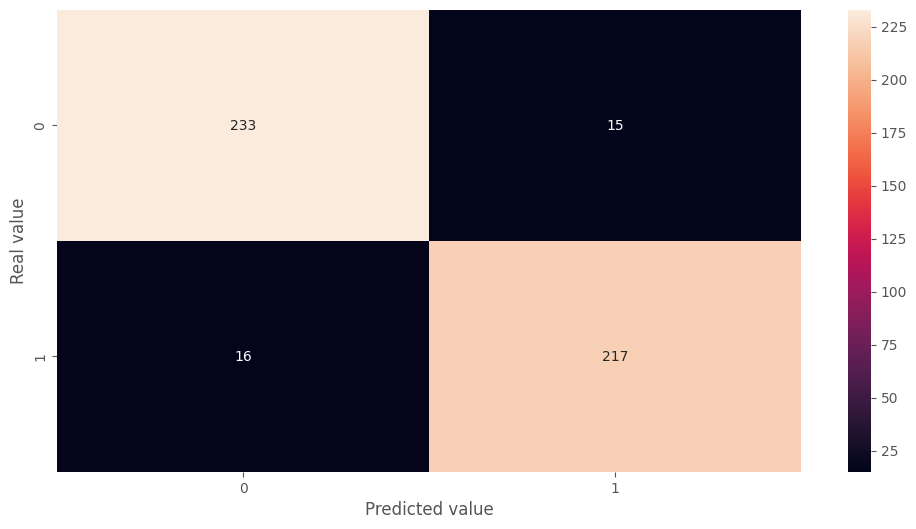

In [142]:
cm_middle = confusion_matrix(y_test, model_middle_prediction)

sns.heatmap(cm_middle, annot=True, fmt="d")
plt.ylabel('Real value')
plt.xlabel('Predicted value')
plt.show()

In [143]:
# model top
X_train, X_test, y_train, y_test = train_test_split(model_data_top.drop('win', axis = 1), model_data_top['win'], test_size=0.3, random_state=123)
train = X_train.join(y_train)
test = X_test.join(y_test)

train.drop('lane', axis = 1, inplace = True)
test.drop('lane', axis = 1, inplace = True)

scaler = MinMaxScaler()
train_normalized = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
test_normalizd = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

model_top = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_top.summary()

Optimization terminated successfully.
         Current function value: 0.175541
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1159
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                           14
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7463
Time:                        23:44:31   Log-Likelihood:                -203.45
converged:                       True   LL-Null:                       -802.05
Covariance Type:            nonrobust   LLR p-value:                6.934e-247
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.4863      0.786      5.705      0.000       2.945       6.028
kills                           7.9485      1.989      3.996      0.000       4.050      11.847
assists                         4.2797      1.461      2.929      0.003       1.416       7.143
deaths                         -1.1736      1.099     -1.068      0.286      -3.328       0.980
champExperience                -1.1421      2.899     -0.394      0.694      -6.824       4.539
dragonKills                     0.7131      1.079      0.661      0.509      -1.403       2.829
baronKills                     -0.7029      1.539     -0.457      0.648      -3.719       2.314
goldEarned                    -12.4317      3.555     -3.497      0.000     -19.399      -5.465
totalDamageDealtToChampions    -1.3505      1.736     -0.778      0.437      -4.753       2.052
totalHeal                       1.1406      1.304      0.875      0.382      -1.415       3.696
totalMinionsKilled              3.1663      1.275      2.484      0.013       0.668       5.665
turretTakedowns                 8.6271      1.052      8.203      0.000       6.566      10.688
turretsLost                   -17.6389      1.313    -13.430      0.000     -20.213     -15.065
visionScore                     0.3700      1.830      0.202      0.840      -3.217       3.957
timePlayed                     12.6795      1.781      7.118      0.000       9.188      16.171
===============================================================================================
"""

In [144]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

Optimization terminated successfully.
         Current function value: 0.175559
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1159
Model:                          Logit   Df Residuals:                     1145
Method:                           MLE   Df Model:                           13
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7463
Time:                        23:44:32   Log-Likelihood:                -203.47
converged:                       True   LL-Null:                       -802.05
Covariance Type:            nonrobust   LLR p-value:                7.230e-248
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.5451      0.731      6.214      0.000       3.112       5.979
kills                           7.9718      1.985      4.015      0.000       4.080      11.863
assists                         4.3007      1.458      2.949      0.003       1.442       7.159
deaths                         -1.2169      1.078     -1.128      0.259      -3.331       0.897
champExperience                -1.2815      2.816     -0.455      0.649      -6.801       4.238
dragonKills                     0.7198      1.078      0.668      0.504      -1.393       2.833
baronKills                     -0.6884      1.534     -0.449      0.654      -3.695       2.319
goldEarned                    -12.4582      3.548     -3.511      0.000     -19.413      -5.504
totalDamageDealtToChampions    -1.3391      1.735     -0.772      0.440      -4.740       2.062
totalHeal                       1.1397      1.301      0.876      0.381      -1.411       3.690
totalMinionsKilled              3.1642      1.272      2.487      0.013       0.670       5.658
turretTakedowns                 8.6335      1.051      8.218      0.000       6.574      10.693
turretsLost                   -17.6660      1.308    -13.505      0.000     -20.230     -15.102
timePlayed                     12.8781      1.492      8.631      0.000       9.954      15.803
===============================================================================================
"""

In [145]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

Optimization terminated successfully.
         Current function value: 0.175641
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1159
Model:                          Logit   Df Residuals:                     1146
Method:                           MLE   Df Model:                           12
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7462
Time:                        23:44:32   Log-Likelihood:                -203.57
converged:                       True   LL-Null:                       -802.05
Covariance Type:            nonrobust   LLR p-value:                7.783e-249
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.5168      0.728      6.205      0.000       3.090       5.943
kills                           7.9592      1.984      4.011      0.000       4.070      11.848
assists                         4.2926      1.458      2.945      0.003       1.436       7.150
deaths                         -1.2045      1.078     -1.117      0.264      -3.317       0.908
champExperience                -1.2434      2.817     -0.441      0.659      -6.765       4.278
dragonKills                     0.7591      1.074      0.707      0.480      -1.345       2.863
goldEarned                    -12.4426      3.547     -3.508      0.000     -19.394      -5.491
totalDamageDealtToChampions    -1.3176      1.733     -0.760      0.447      -4.714       2.079
totalHeal                       1.1384      1.300      0.876      0.381      -1.409       3.686
totalMinionsKilled              3.1650      1.275      2.482      0.013       0.666       5.664
turretTakedowns                 8.6012      1.047      8.218      0.000       6.550      10.653
turretsLost                   -17.6223      1.302    -13.533      0.000     -20.175     -15.070
timePlayed                     12.8037      1.484      8.626      0.000       9.895      15.713
===============================================================================================
"""

In [146]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + dragonKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

Optimization terminated successfully.
         Current function value: 0.175725
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1159
Model:                          Logit   Df Residuals:                     1147
Method:                           MLE   Df Model:                           11
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7461
Time:                        23:44:33   Log-Likelihood:                -203.66
converged:                       True   LL-Null:                       -802.05
Covariance Type:            nonrobust   LLR p-value:                8.027e-250
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.4901      0.725      6.197      0.000       3.070       5.910
kills                           8.2392      1.877      4.389      0.000       4.560      11.918
assists                         4.0538      1.348      3.006      0.003       1.411       6.697
deaths                         -1.1756      1.073     -1.096      0.273      -3.278       0.927
dragonKills                     0.8267      1.063      0.778      0.437      -1.256       2.910
goldEarned                    -13.4757      2.674     -5.040      0.000     -18.716      -8.235
totalDamageDealtToChampions    -1.3859      1.721     -0.805      0.421      -4.759       1.987
totalHeal                       1.1236      1.296      0.867      0.386      -1.417       3.664
totalMinionsKilled              3.2258      1.267      2.547      0.011       0.743       5.708
turretTakedowns                 8.7246      1.009      8.643      0.000       6.746      10.703
turretsLost                   -17.5544      1.290    -13.609      0.000     -20.083     -15.026
timePlayed                     12.7029      1.462      8.687      0.000       9.837      15.569
===============================================================================================
"""

In [147]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

Optimization terminated successfully.
         Current function value: 0.175992
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1159
Model:                          Logit   Df Residuals:                     1148
Method:                           MLE   Df Model:                           10
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7457
Time:                        23:44:33   Log-Likelihood:                -203.98
converged:                       True   LL-Null:                       -802.05
Covariance Type:            nonrobust   LLR p-value:                9.732e-251
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.4963      0.723      6.220      0.000       3.080       5.913
kills                           8.3083      1.875      4.432      0.000       4.634      11.982
assists                         4.0494      1.348      3.004      0.003       1.408       6.691
deaths                         -1.1928      1.071     -1.114      0.265      -3.291       0.906
goldEarned                    -13.5687      2.663     -5.096      0.000     -18.787      -8.350
totalDamageDealtToChampions    -1.3960      1.723     -0.810      0.418      -4.773       1.981
totalHeal                       1.1602      1.290      0.900      0.368      -1.368       3.688
totalMinionsKilled              3.2036      1.263      2.537      0.011       0.729       5.679
turretTakedowns                 8.8048      1.007      8.747      0.000       6.832      10.778
turretsLost                   -17.5596      1.291    -13.606      0.000     -20.089     -15.030
timePlayed                     12.8745      1.446      8.903      0.000      10.040      15.709
===============================================================================================
"""

In [148]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + goldEarned + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

Optimization terminated successfully.
         Current function value: 0.176280
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1159
Model:                          Logit   Df Residuals:                     1149
Method:                           MLE   Df Model:                            9
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7453
Time:                        23:44:33   Log-Likelihood:                -204.31
converged:                       True   LL-Null:                       -802.05
Covariance Type:            nonrobust   LLR p-value:                1.143e-251
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.5655      0.718      6.361      0.000       3.159       5.972
kills                  7.7981      1.751      4.453      0.000       4.366      11.230
assists                3.8478      1.322      2.912      0.004       1.258       6.438
deaths                -1.3170      1.058     -1.245      0.213      -3.391       0.757
goldEarned           -13.9129      2.619     -5.312      0.000     -19.047      -8.779
totalHeal              1.1494      1.291      0.890      0.373      -1.382       3.681
totalMinionsKilled     3.0154      1.239      2.433      0.015       0.586       5.444
turretTakedowns        8.9015      0.998      8.920      0.000       6.946      10.858
turretsLost          -17.5122      1.287    -13.612      0.000     -20.034     -14.991
timePlayed            12.7782      1.440      8.872      0.000       9.955      15.601
======================================================================================
"""

In [149]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + goldEarned + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

Optimization terminated successfully.
         Current function value: 0.176631
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1159
Model:                          Logit   Df Residuals:                     1150
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7448
Time:                        23:44:34   Log-Likelihood:                -204.71
converged:                       True   LL-Null:                       -802.05
Covariance Type:            nonrobust   LLR p-value:                1.357e-252
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.6287      0.715      6.474      0.000       3.227       6.030
kills                  7.6881      1.738      4.423      0.000       4.281      11.095
assists                3.7985      1.321      2.876      0.004       1.210       6.387
deaths                -1.4676      1.046     -1.403      0.161      -3.518       0.582
goldEarned           -13.4899      2.564     -5.262      0.000     -18.515      -8.465
totalMinionsKilled     2.8991      1.228      2.360      0.018       0.492       5.307
turretTakedowns        8.9133      0.997      8.943      0.000       6.960      10.867
turretsLost          -17.5075      1.287    -13.604      0.000     -20.030     -14.985
timePlayed            12.9638      1.427      9.086      0.000      10.167      15.760
======================================================================================
"""

In [150]:
model_top = smf.logit(formula = 'win ~ kills + assists + goldEarned + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

Optimization terminated successfully.
         Current function value: 0.177488
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1159
Model:                          Logit   Df Residuals:                     1151
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7435
Time:                        23:44:34   Log-Likelihood:                -205.71
converged:                       True   LL-Null:                       -802.05
Covariance Type:            nonrobust   LLR p-value:                2.693e-253
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.2844      0.665      6.444      0.000       2.981       5.587
kills                  8.2420      1.686      4.888      0.000       4.937      11.547
assists                3.9038      1.311      2.978      0.003       1.335       6.473
goldEarned           -15.2008      2.270     -6.697      0.000     -19.650     -10.752
totalMinionsKilled     3.4693      1.156      3.000      0.003       1.203       5.736
turretTakedowns        9.3297      0.961      9.711      0.000       7.447      11.213
turretsLost          -17.7256      1.287    -13.777      0.000     -20.247     -15.204
timePlayed            13.1845      1.428      9.232      0.000      10.385      15.984
======================================================================================
"""

In [151]:
model_top_prediction = model_top.predict(test_normalizd) > 0.5
accuracy_top = accuracy_score(model_top_prediction, y_test)
accuracy_top

0.8511066398390342

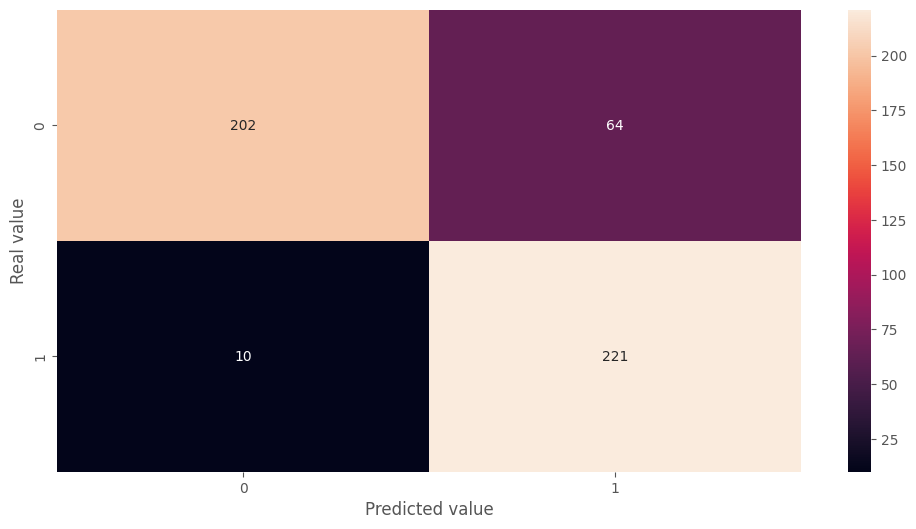

In [152]:
cm_top = confusion_matrix(y_test, model_top_prediction)

sns.heatmap(cm_top, annot=True, fmt="d")
plt.ylabel('Real value')
plt.xlabel('Predicted value')
plt.show()

In [153]:
# model jungle
X_train, X_test, y_train, y_test = train_test_split(model_data_jungle.drop('win', axis = 1), model_data_jungle['win'], test_size=0.3, random_state=123)
train = X_train.join(y_train)
test = X_test.join(y_test)

train.drop('lane', axis = 1, inplace = True)
test.drop('lane', axis = 1, inplace = True)

scaler = MinMaxScaler()
train_normalized = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
test_normalizd = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

model_jungle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

Optimization terminated successfully.
         Current function value: 0.152365
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1030
Model:                          Logit   Df Residuals:                     1015
Method:                           MLE   Df Model:                           14
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7797
Time:                        23:44:36   Log-Likelihood:                -156.94
converged:                       True   LL-Null:                       -712.31
Covariance Type:            nonrobust   LLR p-value:                2.631e-228
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.3211      0.710      3.269      0.001       0.929       3.713
kills                           6.4348      2.412      2.668      0.008       1.708      11.162
assists                         3.7763      1.818      2.077      0.038       0.212       7.340
deaths                         -1.8685      1.316     -1.420      0.156      -4.448       0.711
champExperience                 0.3018      4.642      0.065      0.948      -8.795       9.399
dragonKills                     3.6168      0.815      4.439      0.000       2.020       5.214
baronKills                      1.4875      0.860      1.730      0.084      -0.198       3.173
goldEarned                     -7.9665      3.877     -2.055      0.040     -15.566      -0.368
totalDamageDealtToChampions     1.7816      2.859      0.623      0.533      -3.822       7.385
totalHeal                      -3.7437      1.899     -1.971      0.049      -7.466      -0.021
totalMinionsKilled             -0.3420      1.110     -0.308      0.758      -2.517       1.833
turretTakedowns                 8.1380      1.252      6.499      0.000       5.684      10.592
turretsLost                   -12.4554      1.046    -11.909      0.000     -14.505     -10.406
visionScore                     2.7344      1.505      1.817      0.069      -0.216       5.684
timePlayed                      6.7976      1.419      4.789      0.000       4.016       9.580
===============================================================================================
"""

In [154]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + deaths + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

Optimization terminated successfully.
         Current function value: 0.152368
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1030
Model:                          Logit   Df Residuals:                     1016
Method:                           MLE   Df Model:                           13
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7797
Time:                        23:44:36   Log-Likelihood:                -156.94
converged:                       True   LL-Null:                       -712.31
Covariance Type:            nonrobust   LLR p-value:                2.796e-229
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.3386      0.657      3.562      0.000       1.052       3.625
kills                           6.4008      2.351      2.722      0.006       1.792      11.009
assists                         3.8382      1.551      2.475      0.013       0.799       6.878
deaths                         -1.8655      1.314     -1.420      0.156      -4.441       0.710
dragonKills                     3.6150      0.814      4.440      0.000       2.019       5.211
baronKills                      1.4888      0.859      1.732      0.083      -0.196       3.173
goldEarned                     -7.8185      3.136     -2.493      0.013     -13.965      -1.672
totalDamageDealtToChampions     1.7731      2.854      0.621      0.534      -3.821       7.367
totalHeal                      -3.7489      1.897     -1.976      0.048      -7.467      -0.031
totalMinionsKilled             -0.3337      1.102     -0.303      0.762      -2.494       1.827
turretTakedowns                 8.1256      1.237      6.567      0.000       5.700      10.551
turretsLost                   -12.4691      1.025    -12.160      0.000     -14.479     -10.459
visionScore                     2.7192      1.487      1.829      0.067      -0.195       5.634
timePlayed                      6.8002      1.419      4.793      0.000       4.019       9.581
===============================================================================================
"""

In [155]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + deaths + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

Optimization terminated successfully.
         Current function value: 0.152412
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1030
Model:                          Logit   Df Residuals:                     1017
Method:                           MLE   Df Model:                           12
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7796
Time:                        23:44:36   Log-Likelihood:                -156.98
converged:                       True   LL-Null:                       -712.31
Covariance Type:            nonrobust   LLR p-value:                2.976e-230
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.2651      0.609      3.719      0.000       1.071       3.459
kills                           6.6740      2.174      3.070      0.002       2.413      10.935
assists                         4.0228      1.425      2.824      0.005       1.231       6.815
deaths                         -1.7824      1.284     -1.388      0.165      -4.300       0.735
dragonKills                     3.6942      0.772      4.785      0.000       2.181       5.208
baronKills                      1.5354      0.846      1.814      0.070      -0.123       3.194
goldEarned                     -8.0906      3.005     -2.693      0.007     -13.980      -2.201
totalDamageDealtToChampions     1.5076      2.710      0.556      0.578      -3.805       6.820
totalHeal                      -3.6480      1.858     -1.964      0.050      -7.289      -0.007
turretTakedowns                 8.0314      1.195      6.722      0.000       5.690      10.373
turretsLost                   -12.4564      1.023    -12.171      0.000     -14.462     -10.450
visionScore                     2.7379      1.485      1.843      0.065      -0.173       5.649
timePlayed                      6.7737      1.416      4.782      0.000       3.998       9.550
===============================================================================================
"""

In [156]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + deaths + dragonKills + baronKills + goldEarned + totalHeal + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

Optimization terminated successfully.
         Current function value: 0.152565
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1030
Model:                          Logit   Df Residuals:                     1018
Method:                           MLE   Df Model:                           11
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7794
Time:                        23:44:37   Log-Likelihood:                -157.14
converged:                       True   LL-Null:                       -712.31
Covariance Type:            nonrobust   LLR p-value:                3.382e-231
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.2536      0.608      3.704      0.000       1.061       3.446
kills               7.0660      2.062      3.426      0.001       3.024      11.108
assists             4.2013      1.388      3.027      0.002       1.481       6.921
deaths             -1.7469      1.285     -1.359      0.174      -4.266       0.772
dragonKills         3.6143      0.756      4.780      0.000       2.132       5.096
baronKills          1.4877      0.843      1.765      0.078      -0.165       3.140
goldEarned         -7.5857      2.859     -2.653      0.008     -13.190      -1.981
totalHeal          -3.6610      1.849     -1.980      0.048      -7.284      -0.038
turretTakedowns     8.0067      1.189      6.733      0.000       5.676      10.337
turretsLost       -12.4099      1.015    -12.223      0.000     -14.400     -10.420
visionScore         2.7640      1.483      1.864      0.062      -0.142       5.670
timePlayed          6.8537      1.410      4.859      0.000       4.089       9.618
===================================================================================
"""

In [157]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + dragonKills + baronKills + goldEarned + totalHeal + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

Optimization terminated successfully.
         Current function value: 0.153468
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1030
Model:                          Logit   Df Residuals:                     1019
Method:                           MLE   Df Model:                           10
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7781
Time:                        23:44:37   Log-Likelihood:                -158.07
converged:                       True   LL-Null:                       -712.31
Covariance Type:            nonrobust   LLR p-value:                7.876e-232
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9345      0.557      3.474      0.001       0.843       3.026
kills               7.2722      2.065      3.522      0.000       3.225      11.319
assists             3.7353      1.344      2.778      0.005       1.100       6.370
dragonKills         3.8355      0.740      5.185      0.000       2.386       5.285
baronKills          1.5291      0.836      1.829      0.067      -0.110       3.168
goldEarned         -8.4751      2.776     -3.054      0.002     -13.915      -3.035
totalHeal          -3.2831      1.798     -1.826      0.068      -6.807       0.241
turretTakedowns     8.4907      1.145      7.414      0.000       6.246      10.735
turretsLost       -12.6238      1.008    -12.519      0.000     -14.600     -10.647
visionScore         2.9700      1.485      2.001      0.045       0.060       5.880
timePlayed          6.7755      1.406      4.820      0.000       4.021       9.530
===================================================================================
"""

In [158]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + dragonKills + baronKills + goldEarned + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

Optimization terminated successfully.
         Current function value: 0.155285
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1030
Model:                          Logit   Df Residuals:                     1020
Method:                           MLE   Df Model:                            9
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7755
Time:                        23:44:38   Log-Likelihood:                -159.94
converged:                       True   LL-Null:                       -712.31
Covariance Type:            nonrobust   LLR p-value:                4.426e-232
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.7687      0.544      3.254      0.001       0.703       2.834
kills               7.0803      2.027      3.493      0.000       3.107      11.053
assists             3.3351      1.315      2.537      0.011       0.758       5.912
dragonKills         3.4921      0.710      4.915      0.000       2.100       4.885
baronKills          1.2323      0.815      1.512      0.131      -0.365       2.830
goldEarned         -8.3026      2.737     -3.034      0.002     -13.666      -2.939
turretTakedowns     8.4578      1.148      7.365      0.000       6.207      10.709
turretsLost       -12.5079      0.993    -12.599      0.000     -14.454     -10.562
visionScore         2.8474      1.473      1.933      0.053      -0.039       5.734
timePlayed          6.1217      1.337      4.579      0.000       3.501       8.742
===================================================================================
"""

In [159]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + dragonKills + goldEarned + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

Optimization terminated successfully.
         Current function value: 0.156417
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                 1030
Model:                          Logit   Df Residuals:                     1021
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.7738
Time:                        23:44:38   Log-Likelihood:                -161.11
converged:                       True   LL-Null:                       -712.31
Covariance Type:            nonrobust   LLR p-value:                1.164e-232
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.6921      0.538      3.145      0.002       0.637       2.747
kills               7.1018      2.030      3.498      0.000       3.123      11.081
assists             3.4308      1.316      2.607      0.009       0.852       6.010
dragonKills         3.7806      0.689      5.484      0.000       2.429       5.132
goldEarned         -8.1832      2.735     -2.992      0.003     -13.544      -2.822
turretTakedowns     8.5852      1.149      7.473      0.000       6.334      10.837
turretsLost       -12.5814      0.991    -12.702      0.000     -14.523     -10.640
visionScore         3.1343      1.469      2.134      0.033       0.255       6.013
timePlayed          6.2875      1.331      4.723      0.000       3.678       8.897
===================================================================================
"""

In [160]:
model_jungle_prediction = model_jungle.predict(test_normalizd) > 0.5
accuracy_jungle = accuracy_score(model_jungle_prediction, y_test)
accuracy_jungle

0.9321266968325792

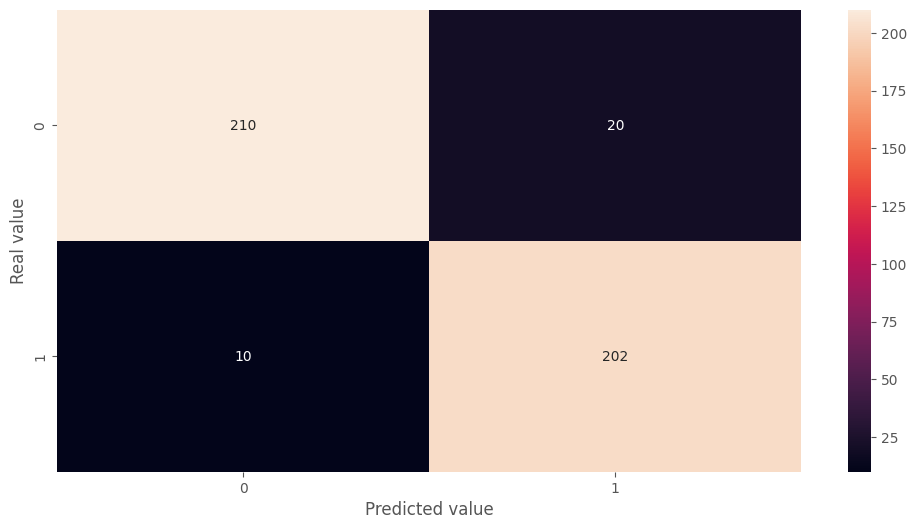

In [161]:
cm_jungle = confusion_matrix(y_test, model_jungle_prediction)

sns.heatmap(cm_jungle, annot=True, fmt="d")
plt.ylabel('Real value')
plt.xlabel('Predicted value')
plt.show()

### Podsumowanie modeli

In [162]:
print('Accuracy score wyestymowanych modeli:')
print(f'Accuracy score - model top: {round(accuracy_top,4) * 100}%')
print(f'Accuracy score - model middle: {round(accuracy_middle,4) * 100}%')
print(f'Accuracy score - model bottom: {round(accuracy_bottom,4) * 100}%')
print(f'Accuracy score - model jungle: {round(accuracy_jungle,4) * 100}%')

Accuracy score wyestymowanych modeli:
Accuracy score - model top: 85.11%
Accuracy score - model middle: 93.56%
Accuracy score - model bottom: 92.32000000000001%
Accuracy score - model jungle: 93.21000000000001%


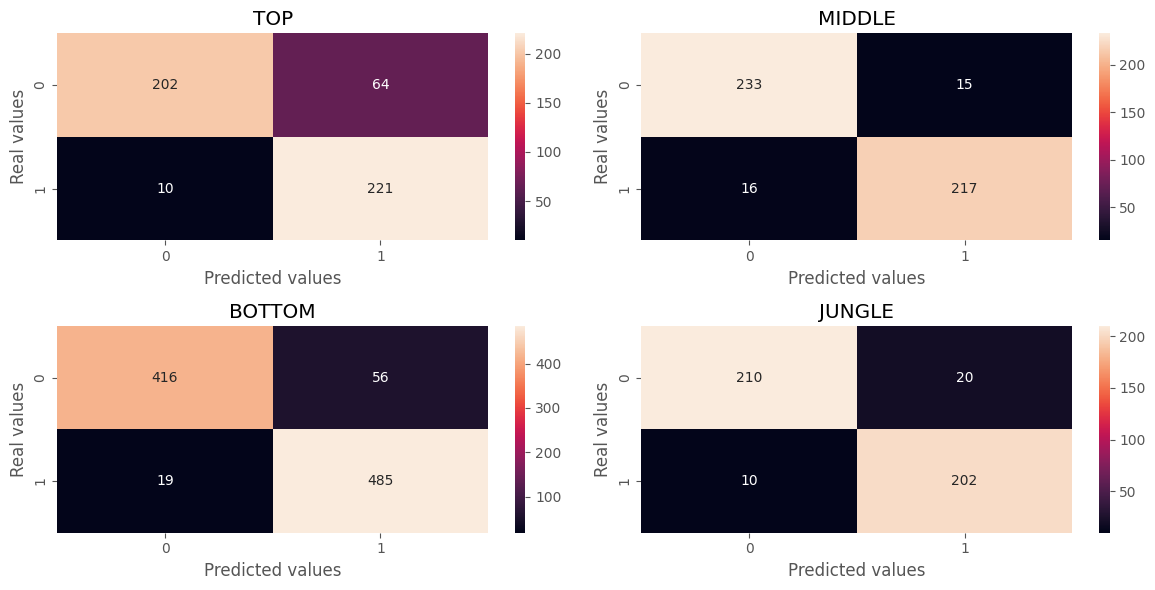

In [163]:
fig, ax = plt.subplots(2, 2)

sns.heatmap(cm_top, annot=True, fmt="d", ax=ax[0,0])
ax[0,0].set_xlabel('Predicted values')
ax[0,0].set_ylabel('Real values')
ax[0,0].set_title('TOP')

sns.heatmap(cm_middle, annot=True, fmt="d", ax=ax[0,1])
ax[0,1].set_xlabel('Predicted values')
ax[0,1].set_ylabel('Real values')
ax[0,1].set_title('MIDDLE')

sns.heatmap(cm_bottom, annot=True, fmt="d", ax=ax[1,0])
ax[1,0].set_xlabel('Predicted values')
ax[1,0].set_ylabel('Real values')
ax[1,0].set_title('BOTTOM')

sns.heatmap(cm_jungle, annot=True, fmt="d", ax=ax[1,1])
ax[1,1].set_xlabel('Predicted values')
ax[1,1].set_ylabel('Real values')
ax[1,1].set_title('JUNGLE')

plt.tight_layout()
plt.show()

### Wnioski

Dla każdej z linii (Top, Mid, Bot, Jungle) istnieją specyficzne zmienne, które mają
znaczący wpływ na rezultat meczów. Dla graczy zajmujących pozycję górnej alei (Top)
najistotniejsze są: zabójstwa, asysty, ilość zdobytego złota, ilość zabitych stworów, zarówno
ilość zniszczonych wież, jak i tych straconych oraz czas gry. Model dla pozycji Top osiągnął
dokładność rzędu 85.11%. Z kolei dla grających na środkowej alei (Mid) najważniejsze są:
zabójstwa, asysty, zgony, zdobyte doświadczenie na danej postaci, zarówno ilość
zniszczonych wież, jak i tych straconych oraz czas gry. Model dla tej linii osiągnął
dokładność 93.55%. Na dolnej alei (Bot) wśród najistotniejszych zmiennych należy
wymienić: asysty, zgony, ilość zabitych stworów, poziom wizji, czas gry oraz zarówno ilość
zniszczonych wież, jak i tych straconych. Poziom dokładności trenowanego modelu dla tej
linii wynosi 92.32%. Ostatnią z linii jest obszar pomiędzy liniami zwany inaczej lasem
(Jungle). W tym przypadku najważniejsze są: zabójstwa, asysty, smoki, zdobyte złoto,
poziom wizji, czas gry, ilość zniszczonych wież oraz tych straconych. Precyzja tego modelu
wynosi 93,21%.
Z powyższej analizy można wyciągnąć następujące wnioski. Średnio rzecz biorąc
gracze na pozycji top i jungle nie powinni przejmować się dużą ilością zgonów, toteż mogą
grać nieco agresywniej. Decydując się na środkową aleję warto mieć uprzednio
doświadczenie na wybranej postaci. Należy również grać ostrożniej, ponieważ zgony na tej
linii w większym stopniu wpływają na wynik meczu niż w przypadku pozycji top i jungle. Na
pozycji jungle należy dążyć do uzyskania przewagi w ilości zgładzonych smoków,
utrzymując przy tym wysoki poziom wizji oraz aktywnie pomagając sprzymierzeńcom.
Natomiast na dolnej alei zamiast dążyć do uzyskania przewagi w zabójstwach, lepiej skupić
się na zabijaniu stworów oraz zapewnianiu odpowiedniego poziomu wizji na mapie.

### Sekcja dodatkowa - Statystyki zawodników

In [169]:
data = data.reset_index(drop = True)
data

,summonerName,kills,assists,deaths,championName,lane,champExperience,dragonKills,baronKills,goldEarned,totalDamageDealtToChampions,totalHeal,totalMinionsKilled,turretTakedowns,turretsLost,visionScore,timePlayed,win
0,Dahyuns thighs,1,17,6,Zyra,BOTTOM,15920,0,0,9685,27715,3432,54,1,5,126,2366,True
1,Dahyuns thighs,1,22,11,Maokai,BOTTOM,15388,0,0,9914,20968,9123,42,1,8,107,2160,False
2,Dahyuns thighs,7,7,11,Zyra,BOTTOM,14332,0,0,12479,39719,4334,64,0,10,127,2425,False
3,Dahyuns thighs,2,14,2,Zyra,BOTTOM,6596,0,0,7736,11371,466,26,2,1,47,1251,True
4,Dahyuns thighs,35,16,11,Qiyana,MIDDLE,25731,0,0,22747,66780,2303,88,3,4,0,1295,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7976,DjRosario,15,8,7,Elise,JUNGLE,21593,4,0,18474,26244,22046,62,4,10,37,2517,False
7977,DjRosario,7,6,1,Elise,JUNGLE,11006,1,1,10707,11289,8161,30,4,1,17,1353,True
7978,DjRosario,5,17,5,Elise,JUNGLE,14838,3,1,12121,19260,12660,33,5,1,15,1826,True
7979,DjRosario,4,5,7,Elise,MIDDLE,12968,0,0,10659,18407,4555,149,1,10,33,1871,False


In [170]:
data_grouped = data.groupby('summonerName')[['kills', 'assists', 'deaths','win']].agg(['mean', lambda x: x.sum()/x.count()])

new_cols = []
for i, j in data_grouped:
    new_cols.append(str(i) + '_' +str(j))
data_grouped.columns = new_cols
data_grouped = data_grouped[['kills_mean', 'assists_mean', 'deaths_mean', 'win_<lambda_0>']]
data_grouped.reset_index(inplace = True)
data_grouped = round(data_grouped, 2)
data_grouped.columns = ['Summoner Name', 'Average number of kills', 'Average number of assists', 'Average number of deaths', 'Win rate']
data_grouped

,Summoner Name,Average number of kills,Average number of assists,Average number of deaths,Win rate
0,Annìvas,5.00,7.29,7.86,0.57
1,Paίn,14.50,10.50,10.83,0.83
2,1 l0ve My ADC,7.33,15.22,6.33,0.56
3,12yoSAOFanBoy,14.20,30.80,12.20,0.40
4,15yo korean girl,8.75,14.75,9.50,0.75
...,...,...,...,...,...
999,Țhe Lich King,3.20,9.60,6.20,0.30
1000,Αffliction,12.44,12.22,9.44,0.33
1001,Ρhoenix,8.00,9.86,5.86,0.57
1002,Σhaco,6.40,9.70,7.50,0.50


In [172]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import plotly.graph_objects as go
from dash.dependencies import Input, Output, State
import dash

if __name__ == '__main__':
    app = JupyterDash(__name__)

    app.layout = html.Div([
        dcc.Input(id='my-input', value=data_grouped['Summoner Name'].iloc[0], type='text'),
        html.Button(id='submit-button', n_clicks=0, children='Szukaj'),
        html.Div(id='my-output', style={'width': '1000px', 'overflowX': 'auto'}),
        html.Div([
            dcc.Graph(id='my-graph', style={'width': '500px'}),
            dcc.Graph(id='my-pie', style={'width': '500px'})
        ], style={'display': 'flex', 'width': '1000px', 'justifyContent': 'space-between'})
    ], style={'width': '100%', 'margin': '0 auto'})

    @app.callback(
        [Output('my-output', 'children'),
         Output('my-graph', 'figure'),
         Output('my-pie', 'figure')],
        [Input('submit-button', 'n_clicks')],
        [State('my-input', 'value')]
    )
    def update_output_div(n_clicks, input_value):
        if n_clicks > 0:
            if input_value in data_grouped['Summoner Name'].values:
                filtered_df = data_grouped[data_grouped['Summoner Name'] == input_value]
            else:
                filtered_df = data_grouped[data_grouped['Summoner Name'] == 'Annivas']

            table = dash_table.DataTable(
                data=filtered_df.to_dict('records'),
                columns=[{'name': i, 'id': i} for i in filtered_df.columns],
                style_cell={'textAlign': 'left', 'padding': '10px'},
                style_header={'backgroundColor': 'powderblue', 'fontWeight': 'bold'},
                style_data_conditional=[
                    {'if': {'row_index': 'odd'}, 'backgroundColor': 'lavender'}
                ],
                style_table={'width': '100%', 'maxHeight': '500px', 'overflowY': 'auto'}
            )

            figure = go.Figure(data=[
                go.Bar(name='Average number of kills', x=filtered_df['Summoner Name'], y=filtered_df['Average number of kills'], marker_color='lightsalmon'),
                go.Bar(name='Average number of assists', x=filtered_df['Summoner Name'], y=filtered_df['Average number of assists'], marker_color='palevioletred'),
                go.Bar(name='Average number of deaths', x=filtered_df['Summoner Name'], y=filtered_df['Average number of deaths'], marker_color='cornflowerblue')
            ])
            figure.update_layout(
                autosize=False,
                width=500,
                height=500,
                margin=dict(l=50, r=50, b=100, t=100, pad=4),
                paper_bgcolor="mintcream",
                barmode='group'
            )

            pie = go.Figure(data=[
                go.Pie(labels=['Win', 'Loss'], values=[filtered_df['Win rate'].iloc[0], 1 - filtered_df['Win rate'].iloc[0]], hole=0.3, marker_colors=['skyblue', 'peachpuff'])
            ])
            pie.update_layout(
                autosize=False,
                width=500,
                height=500,
                margin=dict(l=50, r=50, b=100, t=100, pad=4),
                paper_bgcolor="mintcream"
            )

            return table, figure, pie
        else:
            return dash.no_update, dash.no_update, dash.no_update

    app.run_server(mode="inline", port=8094)


### Sekcja dodatkowa - Zależności między zmiennymi w podziale na pozycje

In [173]:
data['kda']=round((data['kills']+data['assists'])/data['deaths'],2)
data['timePlayed']=round(data['timePlayed']/60,0)

In [174]:
app = JupyterDash(__name__)
df=data
column_names = df.columns.tolist()
column_names = [col for col in column_names if col not in ['win', 'championName', 'summonerName','lane','kills','assists','deaths']]
lane_values = df['lane'].unique()

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Dropdown(
                id='xaxis-column',
                options=[{'label': i, 'value': i} for i in column_names],
                value='totalDamageDealtToChampions' 
            ),
            dcc.RadioItems(
                id='xaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                inline=True
            )
        ], style={'width': '48%', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                id='yaxis-column',
                options=[{'label': i, 'value': i} for i in column_names],
                value='kda'
            ),
            dcc.RadioItems(
                id='yaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                inline=True
            )
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),

    dcc.Graph(id='indicator-graphic'),

    dcc.Slider(
        id='number_observ--slider',
        min=df.index.min(),
        max=df.index.max(),
        step=None,
        value=df.index.max()
    )
])

@app.callback(
    Output('indicator-graphic', 'figure'),
    Input('xaxis-column', 'value'),
    Input('yaxis-column', 'value'),
    Input('xaxis-type', 'value'),
    Input('yaxis-type', 'value'),
    Input('number_observ--slider', 'value'))
def update_graph(xaxis_column_name, yaxis_column_name,
                 xaxis_type, yaxis_type,
                 numb_obs_value):
    dff = df.loc[:numb_obs_value]

    fig = px.scatter(data_frame=dff,
                 x=xaxis_column_name,
                 y=yaxis_column_name,
                 color='lane',
                 hover_name='summonerName',
                 template='plotly_dark')

    fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')

    fig.update_xaxes(title=xaxis_column_name,
                     type='linear' if xaxis_type == 'Linear' else 'log')

    fig.update_yaxes(title=yaxis_column_name,
                     type='linear' if yaxis_type == 'Linear' else 'log')

    return fig


app.run_server(mode='inline', port=8905)